In [82]:
# Import libraries
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import powerlaw
import random
from collections import defaultdict

In [23]:
# Load the dataset
file_path = "/home/tim/Desktop/Desktop/DELFT/APPLIED PHYSICS - MASTER/Modeling and Data Analysis in Complex Networks/ASSIGNMENTS/ASSIGNMENT 1/SFHH2025.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

In [24]:
# Create an undirected graph from the dataset
G = nx.Graph()

# Add edges, ignoring time steps
edges = df[['id1', 'id2']].drop_duplicates().values.tolist()
G.add_edges_from(edges)

# 1. Number of nodes (N)
N = len(G.nodes())

# 2. Number of links (L)
L = len(G.edges())

# 3. Compute degree of each node
degrees = np.array([d for _, d in G.degree()])

# 4. Compute the average degree E[D]
E_D = np.mean(degrees)

# 5. Compute the standard deviation of the degree sqrt(Var[D])
std_D = np.std(degrees)

# Print results
print("Number of nodes (N):", N)
print("Number of links (L):", L)
print("Average degree (E[D]):", E_D)
print("Standard deviation of the degree (sqrt(Var[D])):", std_D)

Number of nodes (N): 401
Number of links (L): 9415
Average degree (E[D]): 46.957605985037404
Standard deviation of the degree (sqrt(Var[D])): 29.918521078014955


A2

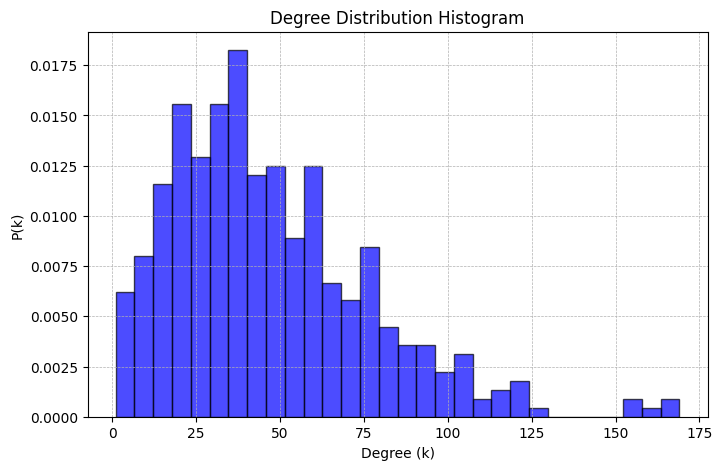

In [25]:
# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(degrees, bins=30, color="blue", alpha=0.7, edgecolor="black", density=True)

# Set y-axis to log scale
# plt.yscale("log")

# Labels and title
plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.title("Degree Distribution Histogram")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


Looks like ER random model --> needs further assessment

A3

In [ ]:
#Use nx to compute assortativity
assortativity = nx.degree_assortativity_coefficient(G)
print("Degree assortativity coefficient (ρD):", assortativity)

Degree assortativity coefficient (ρD): -0.08190596963063947


ρ D <0 (Disassortative Mixing): High-degree nodes tend to connect to low-degree nodes. This is often seen in technological and biological networks (e.g., power grids, metabolic networks).If your dataset represents a contact network, a positive assortativity (ρD>0ρ D​	 >0) suggests that individuals with many contacts tend to interact with other well-connected individuals. A negative assortativity (ρD<0ρ D<0) suggests that well-connected individuals interact more frequently with those who have fewer connections, which is often seen in epidemic spread models.

A4

In [27]:
#Use nx to compute clustering coefficient
clustering_local = nx.clustering(G)  # Returns a dictionary {node: c_i}
C_avg = nx.average_clustering(G)
print("Average clustering coefficient (C):", C_avg)

Average clustering coefficient (C): 0.2812358620467742


A5

In [28]:
#Use nx to compute average shortest path length
E_H = nx.average_shortest_path_length(G)
print("Average hopcount (E[H]):", E_H)
H_max = nx.diameter(G)
print("Network diameter (Hmax):", H_max)

Average hopcount (E[H]): 1.9547007481296759
Network diameter (Hmax): 4


Physical Meaning
Small E[H]E[H] → The network is well-connected; on average, nodes are close to each other.Large E[H]E[H] → Nodes are far apart, meaning communication or spreading processes take more steps.Small Hmax⁡H max​	  → The network is compact; the worst-case path is short.Large Hmax⁡H max​	  → The network has long chains or poorly connected parts.

A6

In [30]:
#Use nx to compute the expected clustering coefficient for a random network
E_H = nx.average_shortest_path_length(G)
print("Average shortest path length (E[H]):", E_H)
C = nx.average_clustering(G)
print("Clustering coefficient (C):", C)
N = G.number_of_nodes()
L = G.number_of_edges()
C_random = L / (N * (N - 1) / 2)
print("Expected clustering coefficient for random network (C_random):", C_random)

Average shortest path length (E[H]): 1.9547007481296759
Clustering coefficient (C): 0.2812358620467742
Expected clustering coefficient for random network (C_random): 0.11739401496259351


A7

In [31]:
# Extract the link weights from the dataset
weights = df.groupby(['id1', 'id2']).size().values  # Counts occurrences per (id1, id2) pair

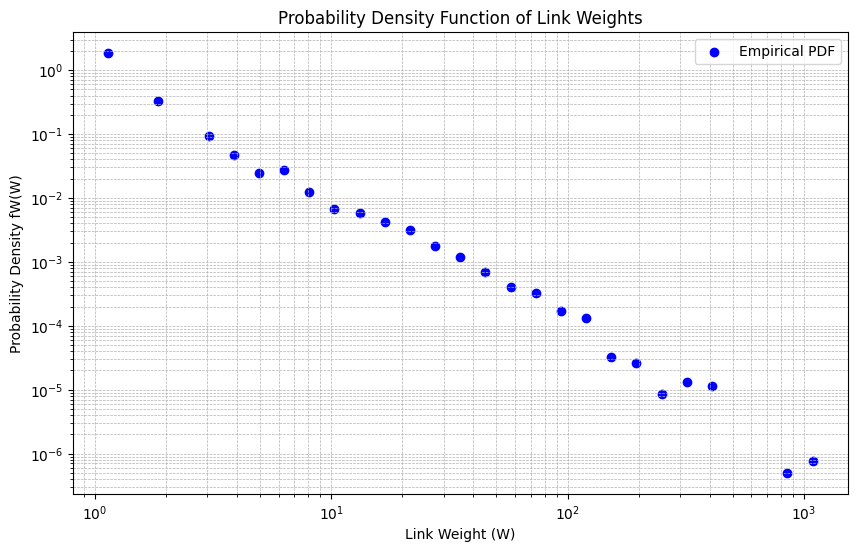

In [59]:
# Define binning strategy: Use logarithmic bins for better power-law visibility
bins = np.logspace(np.log10(min(weights)), np.log10(max(weights)), num=30)

# Compute histogram
hist, bin_edges = np.histogram(weights, bins=bins, density=True)

# Compute bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot PDF
plt.figure(figsize=(10,6))
plt.scatter(bin_centers, hist, marker='o', label="Empirical PDF", color="blue")

# Log-log scale for power-law analysis
plt.xscale("log")
plt.yscale("log")

# Labels and title
plt.xlabel("Link Weight (W)")
plt.ylabel("Probability Density fW(W)")
plt.title("Probability Density Function of Link Weights")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()


The PDF represents the probability of encountering a link with a given weight.

Calculating best minimal value for power law fit


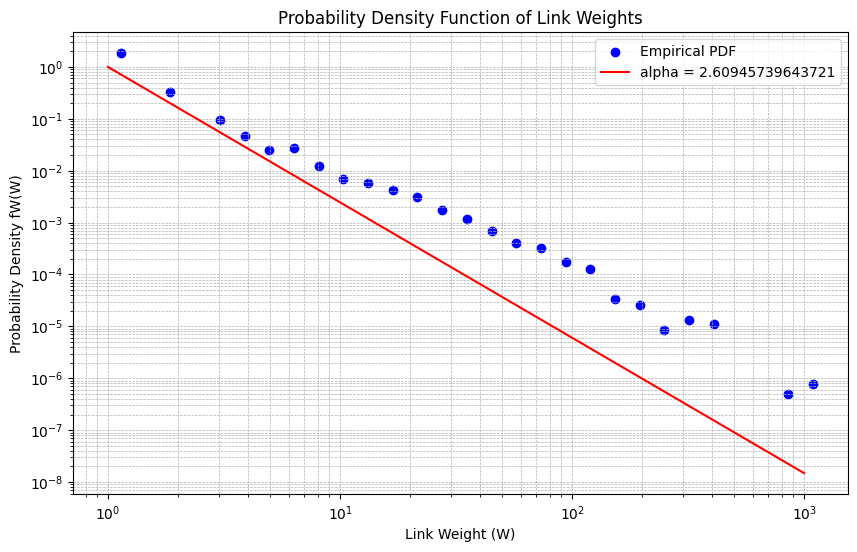

In [61]:
# Fit power-law model
fit = powerlaw.Fit(weights)

# Get exponent alpha
alpha = fit.power_law.alpha

xvalues = np.logspace(0,3,5)
yvalues = xvalues**-(alpha)

plt.figure(figsize=(10,6))
plt.scatter(bin_centers, hist, marker='o', label="Empirical PDF", color="blue")
plt.plot(xvalues,yvalues, label= f'alpha = {alpha}', color='red')

# Log-log scale for power-law analysis
plt.xscale("log")
plt.yscale("log")

# Labels and title
plt.xlabel("Link Weight (W)")
plt.ylabel("Probability Density fW(W)")
plt.title("Probability Density Function of Link Weights")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

B8


In [79]:
# Load the temporal network data
# Assuming Gdata is a list of tuples (time, node_i, node_j)
Gdata = df[['id1', 'id2', 'time_step']].values.tolist()

# Parameters
N = G.number_of_nodes()  # Number of nodes
T = 3493  # Last time step

def simulate_spreading(seed, Gdata, T):
    infected = set([seed])
    I_t = np.zeros(T + 1)
    I_t[0] = 1  # Seed is infected at t=0

    contacts = defaultdict(list)
    for node_i, node_j, time in Gdata:
        contacts[time].append((node_i, node_j))

    for t in range(1, T + 1):
        new_infected = set()
        for node_i, node_j in contacts[t]:
            if node_i in infected and node_j not in infected:
                new_infected.add(node_j)
            elif node_j in infected and node_i not in infected:
                new_infected.add(node_i)
        infected.update(new_infected)
        I_t[t] = len(infected)

    return I_t

# Run simulations
all_I_t = np.zeros((N, T + 1))
for seed in range(N):
    all_I_t[seed] = simulate_spreading(seed, Gdata, T)

# Calculate average and standard deviation
E_I_t = np.mean(all_I_t, axis=0)
Var_I_t = np.std(all_I_t, axis=0)

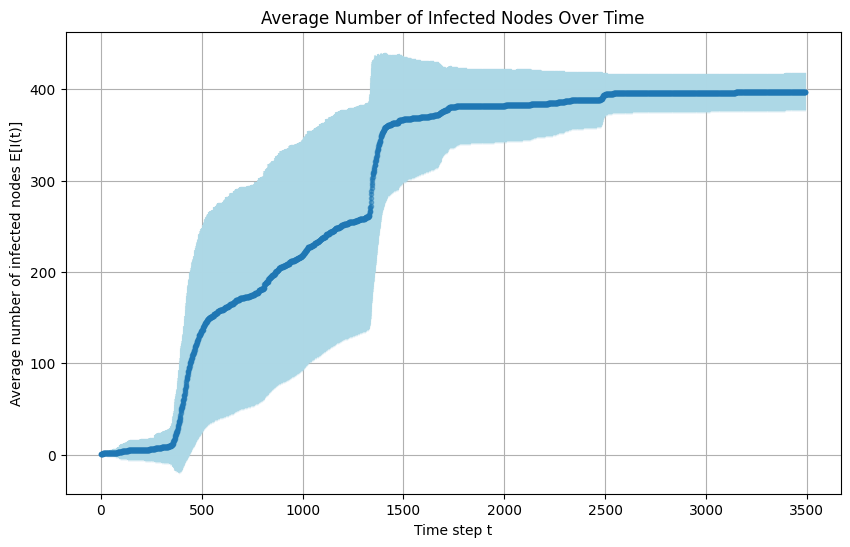

In [80]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.errorbar(range(T + 1), E_I_t, yerr=Var_I_t, fmt='.-', ecolor='lightblue', alpha=0.5, capsize=0.1)
plt.xlabel('Time step t')
plt.ylabel('Average number of infected nodes E[I(t)]')
plt.title('Average Number of Infected Nodes Over Time')
plt.grid(True)
plt.show()

B9

In [81]:
# Parameters
N = G.number_of_nodes()  # Number of nodes
T = 3493  # Last time step
fraction = 0.8  # Fraction of nodes to infect
threshold = fraction * N  # 80% of the nodes

# Calculate the time to infect 80% of the nodes for each seed
time_to_infect_80 = np.full(N, T + 1)  # Initialize with a value greater than T
for seed in range(N):
    I_t = simulate_spreading(seed, Gdata, T)
    if np.any(I_t >= threshold):
        time_to_infect_80[seed] = np.argmax(I_t >= threshold)

# Rank the nodes based on the time to infect 80% of the nodes
ranked_nodes = np.argsort(time_to_infect_80)
R = ranked_nodes + 1  # Node indices start from 1

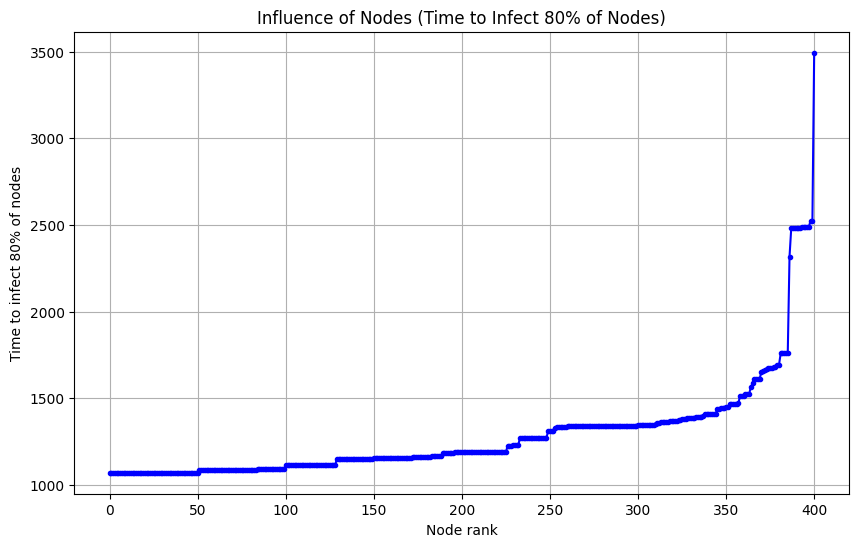

Ranking vector R: [ 17  34  35  36  40  44  43  42  46  47  48  45  49  55  52  53  65  61
  59  54  57  60  58  69  66  26  28   7   3   2  31  30  12  13  10  11
  14   6   9  19  27  20  18  25  24  23  22  21  15   8  16  76  74  73
  72  77  81  38  39  62  75  70  56  71  96  41 103 100 118 119  80 102
  68 126 101  87  99  98  95  82  78  79  67  88 130 131 104 133 108 109
 107 106 114 112 134 105 128 115 111 132 135 145  86 116 139 138 137 136
 141 142  84  85  94  93 120 110  90  89  92  91   4 127 113 123   5  83
 129 146 152 124 125 144 143  64  63 157 148 154 151 150 149 147 155 161
 163 162 166 184 168 165  50 122 117 190 192 159  51 121 140  97  29 185
 181 180 186 191 195 197 196 194 198 199 187 189 160  32  33 201 202 193
 188 164  37 182 153 178 167 158 156 179 209 208 183 200 203 205 215 204
 206 207 213 214 177 171 176 173 174 175 170 232 169 217 224 220 223 222
 221 212 218 219 216 211 231 227 172 228 225 226 233 234 210 236 241 235
 239 238 237 240 230 229 242 244 

In [42]:
# Plot the influence of each node in decreasing order
plt.figure(figsize=(10, 6))
plt.plot(np.sort(time_to_infect_80), '.-', color='blue')
plt.xlabel('Node rank')
plt.ylabel('Time to infect 80% of nodes')
plt.title('Influence of Nodes (Time to Infect 80% of Nodes)')
plt.grid(True)
plt.show()

# Print the ranking vector R
print("Ranking vector R:", R)

B10

In [83]:
# Create a new weighted (aggregated) graph
G_agg = nx.Graph()
# Count contacts (weights) for each pair
edge_counts = df.groupby(['id1', 'id2']).size().reset_index(name='weight')

for _, row in edge_counts.iterrows():
    u, v, w = row['id1'], row['id2'], row['weight']
    G_agg.add_edge(u, v, weight=w)

# 2) Compute degree (unweighted) and strength (weighted degree) for each node
degree_dict = dict(G_agg.degree(weight=None))
strength_dict = dict(G_agg.degree(weight='weight'))

# Sort nodes by descending degree and descending strength
D_sorted = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
S_sorted = sorted(strength_dict.items(), key=lambda x: x[1], reverse=True)

# Extract just the node order
D = [node for node, deg in D_sorted]  # D(1) is highest degree
S = [node for node, wdeg in S_sorted] # S(1) is highest strength

print(f"D: [{' '.join(str(x) for x in D)}]")
print(f"S: [{' '.join(str(x) for x in S)}]")
print(f"R: [{' '.join(str(x) for x in R)}]")

# 3) We already have R from previous steps (time to infect 80% sorted).
#    R(1) is the most influential (fastest to infect 80%).
#    Assume it is stored as a list of node IDs, R[0] being the top influencer.

# 4) Define fractions to test
fractions = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
N = G_agg.number_of_nodes()
n_runs = 1000  # number of tie-handling runs

def random_top_fraction(rank_list, fraction):
    """
    Returns a randomly chosen set of top-fraction nodes from 'rank_list',
    handling any ties at the cutoff by shuffling them. Modify if you need
    a more advanced tie-handling approach.
    """
    top_count = math.ceil(fraction * len(rank_list))
    # If no ties in your data, we can simply pick the top top_count.
    # If there are ties, could incorporate random sampling here.
    return set(rank_list[:top_count])

def recognition_rate(R, X, f):
    """
    | Rf ∩ Xf | / |Rf|
    R is seed-influence ranking, X is degree or strength ranking.
    """
    Rf = random_top_fraction(R, f)
    Xf = random_top_fraction(X, f)
    return len(Rf.intersection(Xf)) / len(Rf) if len(Rf) else 0

recognition_RD = []
recognition_RS = []

for f in fractions:
    vals_RD = []
    vals_RS = []
    for _ in range(n_runs):
        vals_RD.append(recognition_rate(R, D, f))
        vals_RS.append(recognition_rate(R, S, f))
    recognition_RD.append(np.mean(vals_RD))
    recognition_RS.append(np.mean(vals_RS))

D: [19 196 70 79 90 103 86 95 189 171 81 290 94 158 51 69 3 114 246 25 112 183 140 222 198 217 130 2 362 12 354 58 30 123 74 298 59 213 242 54 101 151 37 9 368 191 137 291 34 33 201 60 27 167 7 47 365 122 80 221 363 356 206 26 374 107 194 8 84 15 21 24 109 214 330 190 85 97 67 359 186 238 82 358 28 258 99 286 117 312 11 104 134 55 261 288 18 307 343 273 142 10 304 23 275 56 342 344 31 98 283 323 379 397 378 29 231 204 53 179 185 57 1 5 301 327 252 257 115 192 241 270 289 202 371 333 268 168 4 73 126 45 259 75 41 339 50 44 180 6 280 315 332 200 207 361 243 92 116 263 348 193 124 267 349 143 322 125 370 153 264 100 128 162 239 265 230 398 392 145 139 314 306 178 331 77 14 274 373 66 197 325 346 182 240 319 88 144 318 205 300 188 83 42 341 250 195 256 347 321 20 64 108 110 184 292 169 210 78 208 87 372 111 161 285 293 13 89 399 350 218 251 294 156 233 244 38 39 215 219 160 102 220 35 176 355 46 48 353 369 157 386 271 234 279 387 121 375 209 163 385 336 141 127 164 247 40 175 138 329 172 2

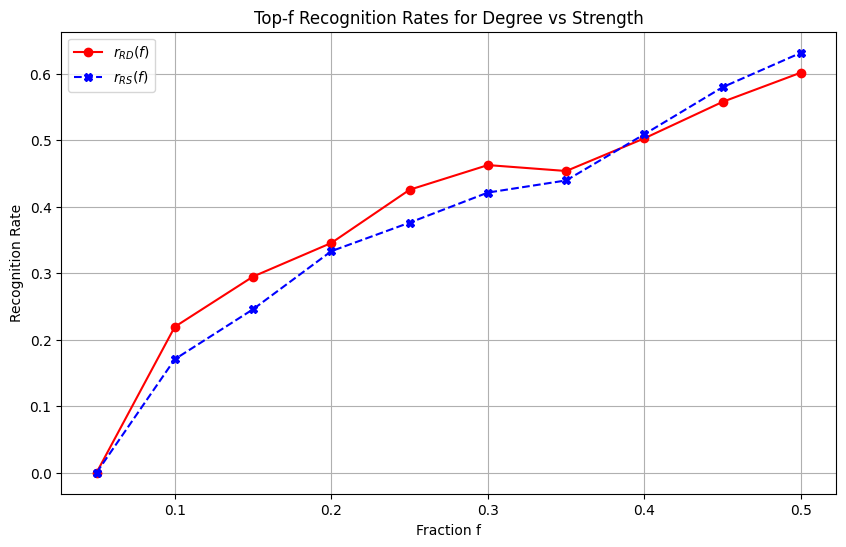

In [92]:
# 5) Plot rR_D(f) and rR_S(f) vs. f
plt.figure(figsize=(10,6))
plt.plot(fractions, recognition_RD, 'o-', label='$r_{RD}(f)$', color='red')
plt.plot(fractions, recognition_RS, 'X--', label='$r_{RS}(f)$', color='blue')
plt.xlabel('Fraction f')
plt.ylabel('Recognition Rate')
plt.title('Top-f Recognition Rates for Degree vs Strength')
plt.grid(True)
plt.legend()
plt.show()

# 6) Interpretation:
# The curve that stays higher indicates a better predictor of nodal influence.

B11

Z: [4 3 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 1 20 21 22 23 24 25 26 2 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 111 112 113 114 115 116 117 118 119 120 121 122 123 124 110 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 

ValueError: x and y must have same first dimension, but have shapes (11,) and (10,)

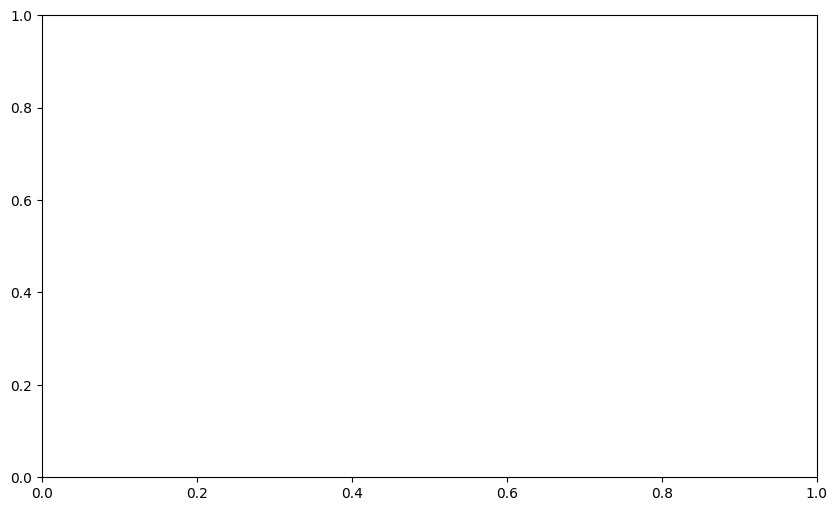

In [ ]:
# 1) Build the aggregated, weighted graph as before (already in G_agg).
# 2) We have degree ranking (D) and strength ranking (S).
# 3) Compute the 'first contact time' (Z) for each node in Gdata.

z_dict = {}
for u, v, time in Gdata:
    # Update earliest contact time for each node
    if u not in z_dict or time < z_dict[u]:
        z_dict[u] = time
    if v not in z_dict or time < z_dict[v]:
        z_dict[v] = time

# If a node has no contacts, assign a large time (or 0) as needed
all_nodes = list(G_agg.nodes())
for node in all_nodes:
    if node not in z_dict:
        z_dict[node] = T + 1  # or some large value

# Sort nodes by ascending Z so that earliest-contact node is first
Z_sorted = sorted(z_dict.items(), key=lambda x: x[1])
Z = [node for node, first_time in Z_sorted]

# Print in the same style as R
print(f"Z: [{' '.join(str(x) for x in Z)}]")

# 4) We already have R, D, S, and fractions, plus the tie-handling logic.

def random_top_fraction(rank_list, fraction):
    top_count = math.ceil(fraction * len(rank_list))
    # Basic approach: just pick the top top_count
    return set(rank_list[:top_count])

def recognition_rate(R, X, f):
    Rf = random_top_fraction(R, f)
    Xf = random_top_fraction(X, f)
    return len(Rf.intersection(Xf)) / len(Rf) if Rf else 0

fractions = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
n_runs = 1000

# 5) Compute rRZ(f) just like rRD(f) and rRS(f)
recognition_RZ = []

for f in fractions:
    vals_RZ = []
    for _ in range(n_runs):
        vals_RZ.append(recognition_rate(R, Z, f))
    recognition_RZ.append(np.mean(vals_RZ))

# 6) Plot rRZ(f) together with the previously computed rRD(f) and rRS(f).
plt.figure(figsize=(10,6))
plt.plot(fractions, recognition_RD, 'o-', label='$r_{RD}(f)$', color='red')
plt.plot(fractions, recognition_RS, 'X--', label='$r_{RS}(f)$', color='blue')
plt.plot(fractions, recognition_RZ, 'x-.', label='$r_{RZ}(f)$', color='green')
plt.xlabel('Fraction f')
plt.ylabel('Recognition Rate')
plt.title('Top-f Recognition Rates: Degree, Strength, and First Contact Time')
plt.grid(True)
plt.legend()
plt.show()

# 7) Brief Interpretation:
# - Compare rRZ(f) with rR_D(f) and rR_S(f):
#   If rRZ(f) is consistently lower, Z is a weaker predictor;
#   if it’s higher in some range, Z can be more relevant.
#   Typically, if a node appears earlier (low Z),
#   it could have more time to spread infection,
#   but that alone might not guarantee it has enough contacts or strength
#   to become a major spreader.

B12